# Social Doors Cerebellum Network PPI Analysis

Author: Haroon Popal 

Code borrowed from [dartbrains](https://dartbrains.org/content/Connectivity.html#psychophysiological-interactions)


In this analysis, we will examine the connectivity of the posterior Crus I/II while account for the activity of either the reward or social networks. The motivation for this analysis is to examine whether the cerebellum is preferentially connected to either network. The social and reward networks were derived from NeuroSynth using the "social" and "reward" terms.

## Set Up

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation, zscore
from sklearn.metrics import pairwise_distances

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference

# Import cerebellum packages
import matplotlib.pyplot as plt
import SUITPy.flatmap as flatmap

import warnings
warnings.filterwarnings('ignore')

/Users/haroonpopal/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


### Helper Functions

In [86]:
def plot_stat_contours(filename, thresh=1, mc='fpr', mc_alpha=0.001, clust_alpha=0.05, view='split', title=''):
    # Find type of analysis
    analysis = 'group_results'
    
    # Find stat map
    stat_filename = os.path.join(outp_dir, analysis,  
                                    filename+'_unc.nii.gz')
    #stat_filename_mc = os.path.join(outp_dir, analysis,  
    #                                filename+'_fpr-'+str(mc_alpha)+'_clust-'+str(clust_alpha)+'.nii.gz')
    stat_filename_mc = os.path.join(outp_dir, analysis,  
                                    filename+'_'+mc+'-'+str(mc_alpha)+'.nii.gz')
    
    # Import stat map as a cerebellum flatmap
    funcdata = flatmap.vol_to_surf(stat_filename_mc,
                                  space='SUIT')
    
    
    
    mc_thresh = threshold_data[filename+'_'+mc+'-'+str(mc_alpha)]
    #print(mc_thresh)
    if mc_thresh == np.inf:
        mc_thresh = 1000

    if view == 'split':
        # Set figure specs
        fig = plt.figure(figsize=(15, 4))
        gs = GridSpec(2, 3)
        ax_img1 = plt.subplot(gs[0, :2])
        ax_img2 = plt.subplot(gs[1, :2])
        
        hemi_lh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img1,
                                cut_coords=range(-65,0, 10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Left Hemisphere',
                                annotate=False)
        hemi_rh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img2,
                                cut_coords=range(66,5, -10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Right Hemisphere',
                                annotate=False)
        hemi_lh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=1)
        hemi_rh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=1)
        
        ax_joint = plt.subplot(gs[:, 2:])
        ax_joint.set(title='Cerebellum flatmap')
        flatmap.plot(data=funcdata, cmap='hot',
                    threshold=[-.1,.1],
                    colorbar=False,
                    render='matplotlib', new_figure=False)
        
    elif view == 'straight':
        hemi_bh = plot_stat_map(stat_filename, threshold=thresh, 
                      cut_coords=range(-65,66, 10), display_mode='x', colorbar=True,
                      cmap='coolwarm', symmetric_cbar=True, title=title)
        hemi_bh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=2)

### Set Paths

In [3]:
bids_dir = '/Users/haroonpopal/OneDrive - Temple University/olson_lab/projects/social_doors/'
os.chdir(bids_dir)

outp_dir = os.path.join(bids_dir, 'derivatives', 'ppi_analysis')
data_dir = os.path.join(bids_dir, 'derivatives','social_doors-nilearn')

if os.path.exists(outp_dir):
    print('Output directory already exists. Continuing will overwrite data.')
else:
    os.makedirs(outp_dir)

Output directory already exists. Continuing will overwrite data.


### Import participant list

In [4]:
subjs_scan_info = pd.read_csv(bids_dir+'derivatives/participants_good.tsv', sep='\t')

subjs_list = list(subjs_scan_info['participant_id'].unique())
len(subjs_list)

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

# Set a temporary grey matter mask
subj_gm_mask = 'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'


Found 63 subjects


In [5]:
subjs_scan_info

,Unnamed: 0,participant_id,age,sex,group
0,0,sub-010,13,F,kid
1,2,sub-013,13,M,kid
2,5,sub-028,15,M,kid
3,6,sub-036,16,F,kid
4,7,sub-5049,12,F,kid
...,...,...,...,...,...
58,76,sub-4069,22,F,college
59,77,sub-6003,23,M,college
60,78,sub-6004,19,M,college
61,79,sub-6005,21,F,college


### Import MRI quality control info

In [6]:
qc_summary = pd.read_csv('derivatives/qc_summary.csv')

# Filter qc summary for only good participants
qc_summary_good = qc_summary[qc_summary['subject'].isin(subjs_list)]
qc_summary_good.head()

,subject,run,rating,artifacts
0,sub-010,mdoors_run-1,4,[]
1,sub-010,mdoors_run-2,3,['head-motion']
2,sub-010,social_run-1,4,[]
3,sub-010,social_run-2,4,[]
8,sub-013,mdoors_run-1,3,"['head-motion','parietal-cutoff']"


# Networks of Interest
We will use [Neuroimaging Meta-Analysis Research Environment (NiMARE)](https://nimare.readthedocs.io/en/stable/index.html) to derive whole brain maps for "social" and "reward" terms.

**Helpful Links:**
- https://nimare.readthedocs.io/en/stable/auto_examples/01_datasets/02_download_neurosynth.html#sphx-glr-auto-examples-01-datasets-02-download-neurosynth-py
- https://nimare.readthedocs.io/en/stable/auto_examples/02_meta-analyses/04_plot_estimators.html#sphx-glr-auto-examples-02-meta-analyses-04-plot-estimators-py


In [7]:
import nimare
from nimare.extract import fetch_neurosynth

/Users/haroonpopal/anaconda3/envs/py37/lib/python3.7/site-packages/nimare/__init__.py:74: FutureWarning: Python 3.6 and 3.7 support is deprecated and will be removed in release 0.1.0 of NiMARE. Consider switching to Python 3.8, 3.9 or 3.10.
  _python_deprecation_warnings()


In [8]:
# Download and convert Neurosynth data to NiMARE format
nm_files = fetch_neurosynth(data_dir=bids_dir+'derivatives/nimare/',
                            version="7",
                            overwrite=False,
                            source="abstract",
                            vocab="terms")

# Note that the files are saved to a new folder within "out_dir" named "neurosynth".
neurosynth_db = nm_files[0]

# Convert neurosynth databace into NiMARE dataset file
neurosynth_dset = nimare.io.convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)


INFO:nimare.extract.utils:Dataset found in /Users/haroonpopal/OneDrive - Temple University/olson_lab/projects/social_doors/derivatives/nimare/neurosynth

INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('source-abstract', 'vocab-terms', 'data-neurosynth', 'version-7')]


File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.


## Neurosynth "Social" Network

In [9]:
# Get all studies for "social"
social_ids = neurosynth_dset.get_studies_by_label("terms_abstract_tfidf__social", 
                                                  label_threshold=0.001)
social_dset = neurosynth_dset.slice(social_ids)

# Get all studies that do no include "social"
all_ids = neurosynth_dset.ids
notterm_ids = sorted(list(set(all_ids) - set(social_ids)))
notsocial_dset = neurosynth_dset.slice(notterm_ids)

In [10]:
# Run the meta-analysis.
# No multiple comparisons correction since you want the unthreshold maps.
meta = nimare.meta.cbma.mkda.MKDAChi2()
results = meta.fit(social_dset, notsocial_dset)
results.save_maps(output_dir=bids_dir+'derivatives/nimare/', prefix='neurosynth_term-social')


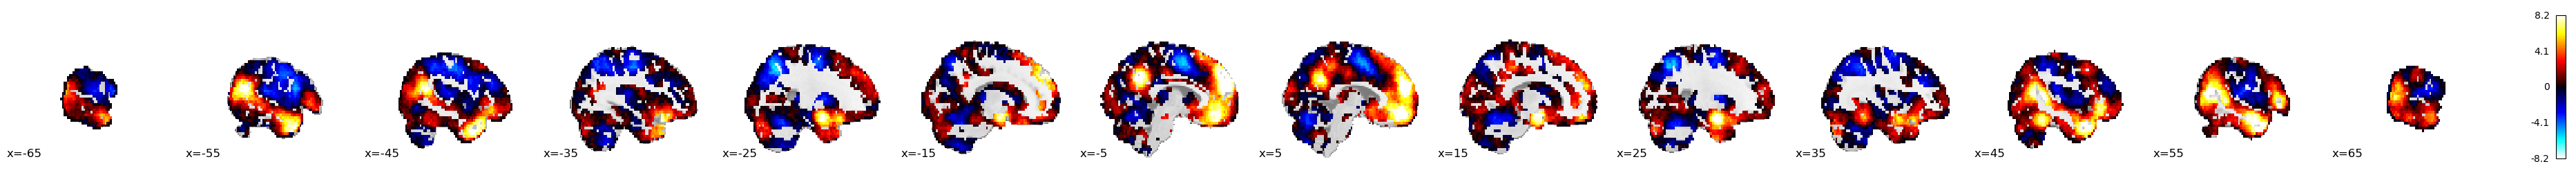

In [11]:
social_net_roi_file = os.path.join(bids_dir,'derivatives','nimare',
                                   'neurosynth_term-social_z_desc-association.nii.gz')
social_net_roi = Brain_Data(social_net_roi_file, mask=subj_gm_mask)

plot_stat_map(social_net_roi.to_nifti(),
             cut_coords=range(-65,66,10), display_mode='x',)

## Neurosynth "Reward" Network

In [12]:
# Get all studies for "reward"
reward_ids = neurosynth_dset.get_studies_by_label("terms_abstract_tfidf__reward", 
                                                  label_threshold=0.001)
reward_dset = neurosynth_dset.slice(reward_ids)

# Get all studies that do no include "social"
all_ids = neurosynth_dset.ids
notterm_ids = sorted(list(set(all_ids) - set(reward_ids)))
notreward_dset = neurosynth_dset.slice(notterm_ids)

In [13]:
# Run the meta-analysis.
# No multiple comparisons correction since you want the unthreshold maps.
meta = nimare.meta.cbma.mkda.MKDAChi2()
results = meta.fit(reward_dset, notreward_dset)
results.save_maps(output_dir=bids_dir+'derivatives/nimare/', prefix='neurosynth_term-reward')

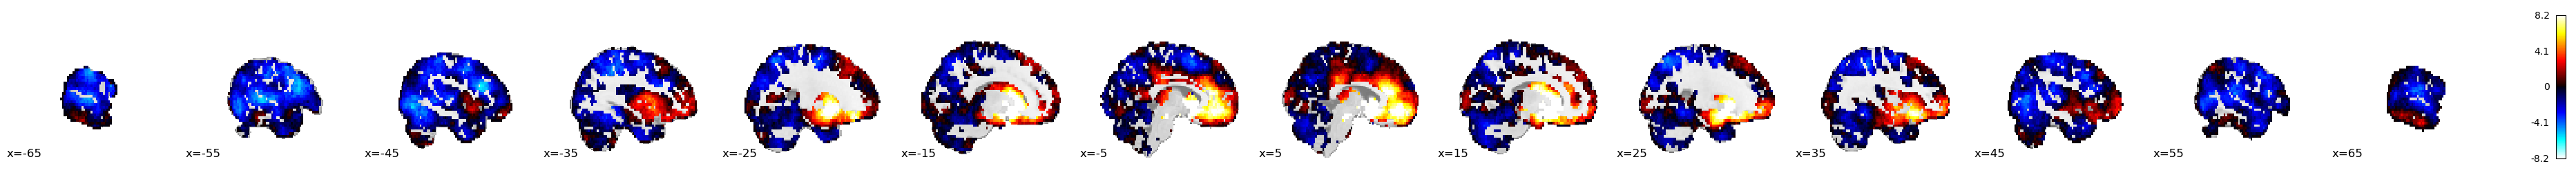

In [14]:
reward_net_roi_file = os.path.join(bids_dir,'derivatives','nimare',
                                   'neurosynth_term-reward_z_desc-association.nii.gz')

reward_net_roi = Brain_Data(reward_net_roi_file, mask=subj_gm_mask)

plot_stat_map(reward_net_roi.to_nifti(),
             cut_coords=range(-65,66,10), display_mode='x',)

## Cerebelllum Region of Interest

The region of interest (ROI) used here is "region 8" from the MDTB cerebellum atlas from [King et al., 2019](https://www.nature.com/articles/s41593-019-0436-x).

In [15]:
roi_names = ['region08']

rois_dict = {}

for n in range(len(roi_names)):
    roi_path = glob.glob(os.path.join(bids_dir, 'derivatives','rois',
                                                    'mdtb_'+roi_names[n]+'.nii.gz'))
    rois_dict[roi_names[n]] = Brain_Data(roi_path, mask=subj_gm_mask)

# Single Subject Analysis
This will complete the PPI analysis for a single subject to explain each step of the process, before running for all participants

## Set up task info

In [16]:
task = 'social'

func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
func_run_names = func_run_names['run'].to_list()

## Find functional data

In [17]:
# Find functinoal runs that passed quality control
func_runs = []
for run in func_run_names:
    func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                   subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])

# Set a grey matter mask
subj_gm_mask = 'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
data = Brain_Data(func_runs, mask=subj_gm_mask)

# Smooth data
fwhm=6
smoothed = data.smooth(fwhm=fwhm)

## Spatial Regression
For each spatial map, estimate subject-specific temporal dynamics (Dobyrakova & Smith, 2022)

In [18]:
x = np.array([social_net_roi.data, reward_net_roi.data])
x.shape

(2, 72537)

In [19]:
y = smoothed.data
y.shape

(260, 72537)

In [20]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x.T, y.T)

networks_df = pd.DataFrame(reg.coef_, columns=['social_network', 'reward_network'])
networks_df

,social_network,reward_network
0,6.143772,-26.166076
1,6.170455,-26.179152
2,6.372396,-26.177650
3,6.406059,-26.202410
4,6.448700,-26.046040
...,...,...
255,6.279676,-26.669209
256,6.215979,-26.904549
257,6.346264,-26.687421
258,6.383491,-26.758874


## Create design matrix

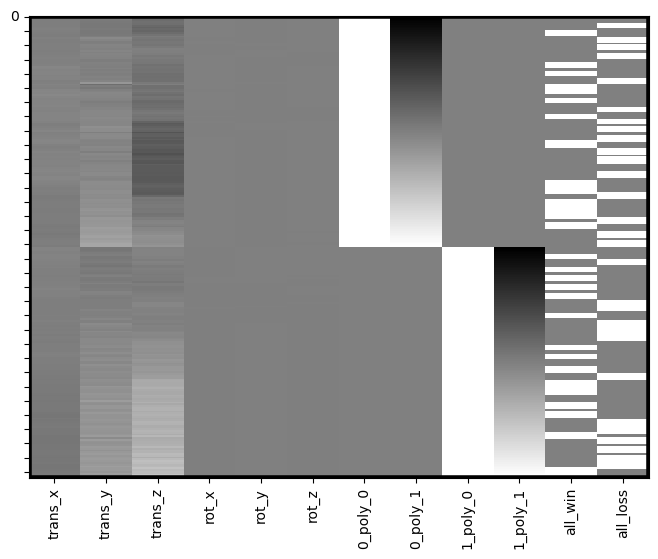

In [21]:
# Set TR info
tr = 2.1
n_tr = len(data)


# Append run design matrices
dm = pd.DataFrame()
for run in func_run_names:
    run_n = int(run[-1])
    
    # Import design matrix for a single run
    temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')

    # Rename the first and second order polynomial regressors so that they do not 
    # regressor between runs
    temp_dm = temp_dm.rename(columns={"poly_0": str(run_n-1)+"_poly_0", "poly_1": str(run_n-1)+"_poly_1"})
    
    # Append design matrix into a longer design matrix
    dm = pd.concat([dm, temp_dm], ignore_index=True)


# Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
dm = dm.fillna(0)

# Create all win and all loss. conditions
dm['all_win'] = dm['positive_win'] + dm['negative_win']
dm['all_loss'] = dm['positive_loss'] + dm['negative_loss']

# Remove irrelevant conditions and create a new dm
ppi_dm = dm.drop(['positive_win', 'positive_loss',
                  'negative_win', 'negative_loss', 
                  'negative', 'positive', 
                  'fixation'], axis=1)


#dm = Design_Matrix(pd.concat([ppi_dm, networks_dm], axis=1), sampling_freq=1/tr)
ppi_dm = Design_Matrix(ppi_dm, sampling_freq=1/tr)

# Plot design matrix
ppi_dm.heatmap()

## Psychophysiological Interaction Analysis

### Add region x condition interaction term

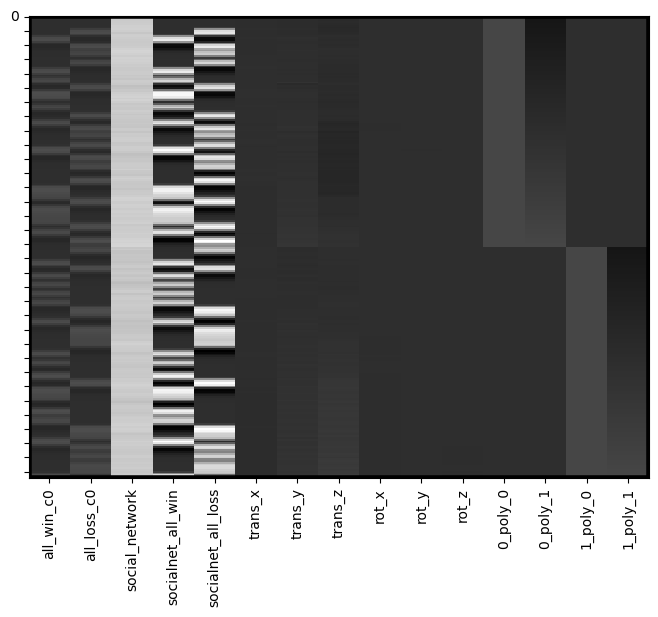

In [22]:
# Find motion regressors
mc_cov = ppi_dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]

# Find polynomial regressors
poly_cov = ppi_dm.loc[:, ppi_dm.columns.str.contains('_poly_')]

# Remove motion and polynomial regressors
ppi_dm = ppi_dm.drop(mc_cov.columns, axis=1)
ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)

# Complete convolution
ppi_dm_conv = ppi_dm.convolve()

# Add ROI time series
#ppi_dm_conv['region08'] = cb_data

# Add network spatial regression data
networks_dm = Design_Matrix(networks_df, sampling_freq=1/tr)
ppi_dm_conv = Design_Matrix(pd.concat([ppi_dm_conv, networks_dm['social_network']], axis=1), sampling_freq=1/tr)


# Create generalized interaction terms
ppi_dm_conv['socialnet_all_win'] = ppi_dm_conv['social_network']*ppi_dm_conv['all_win_c0']
ppi_dm_conv['socialnet_all_loss'] = ppi_dm_conv['social_network']*ppi_dm_conv['all_loss_c0']

# Combine convoluted dm, and motion and polynomial regressors
ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)


ppi_dm_conv_all.heatmap()

### Regress onto the whole brain

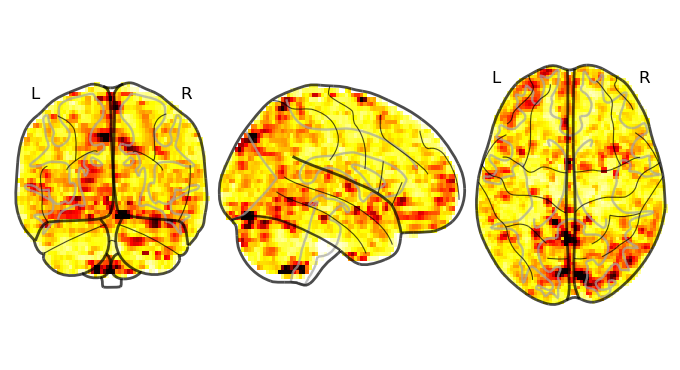

In [23]:
smoothed.X = ppi_dm_conv_all

ppi_stats = smoothed.regress()

# Create all win vs all loss PPI contrast
c1 = np.zeros(len(ppi_stats['beta']))
idx_1 = list(smoothed.X.columns).index('socialnet_all_win')
idx_2 = list(smoothed.X.columns).index('socialnet_all_loss')

c1[idx_1] = 1
c1[idx_2] = -1


cb_r_fixation_ppi = ppi_stats['beta'] * c1

#cb_r_fixation_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='region08_all_win')[0][0])]

#cb_r_fixation_ppi.plot()
plot_glass_brain(cb_r_fixation_ppi.to_nifti())

In [24]:
roi_data = cb_r_fixation_ppi.extract_roi(mask=rois_dict['region08'])
roi_data

-3.8688343098265423

# Group PPI Analysis

In [39]:
# Remove bad participant
subjs_list = [x for x in subjs_list if x != 'sub-4069']

In [26]:
all_sub_ppi_cb = Brain_Data()
all_sub_ppi_roi_df = pd.DataFrame(columns=['subject_id', 'ROI', 'task', 'network', 'beta'])

tasks = ['mdoors', 'social']
networks = ['reward', 'social']


for subj in subjs_list:
    for task in tasks:
        # Import functional runs that passed quality control
        func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
        func_run_names = func_run_names['run'].to_list()

        print('Number of functional runs for '+subj+': '+str(len(func_run_names)))

        # Find functional runs that passed quality control
        func_runs = []
        for run in func_run_names:
            func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                       subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])


        # Import functional data, masked for only grey matter
        mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
        data = Brain_Data(func_runs, mask=mni_gm_mask)


        # Smooth data
        fwhm=6
        smoothed = data.smooth(fwhm=fwhm)

        # Get functional meta data
        n_tr = len(data)


        print('Calculating PPI for '+subj)


        # Create Design matrix for all runs
        dm = pd.DataFrame()
        for run in func_run_names:
            run_n = int(run[-1])
            
            # Import design matrix for a single run
            temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')
            
            # Rename the first and second order polynomial regressors so that they do not 
            # regressor between runs
            temp_dm = temp_dm.rename(columns={"poly_0": str(run_n-1)+"_poly_0", "poly_1": str(run_n-1)+"_poly_1"})

            # Append design matrix into a longer design matrix
            dm = pd.concat([dm, temp_dm], ignore_index=True)

        # Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
        dm = dm.fillna(0)
        
        # Check to make sure raw design matrix has correct data
        if 'positive_win' not in dm.columns:
            continue
        
        # Create all win and all loss. conditions
        dm['all_win'] = dm['positive_win'] + dm['negative_win']
        dm['all_loss'] = dm['positive_loss'] + dm['negative_loss']

        # Remove irrelevant conditions and create a new dm
        ppi_dm = dm.drop(['positive_win', 'positive_loss',
                          'negative_win', 'negative_loss', 
                          'negative', 'positive', 
                          'fixation'], axis=1)
        
        # Convert dataframe to a design matrix
        ppi_dm = Design_Matrix(ppi_dm, sampling_freq=1/tr)
        
        # Find motion regressors
        mc_cov = ppi_dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
        
        # Find polynomial regressors
        poly_cov = ppi_dm.loc[:, ppi_dm.columns.str.contains('_poly_')]
        
        # Remove motion and polynomial regressors
        ppi_dm = ppi_dm.drop(mc_cov.columns, axis=1)
        ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)
        
        # Complete convolution
        ppi_dm_conv = ppi_dm.convolve()

        
        # Define subject data for spatial regression
        # X has already been defined as the social and reward network maps from neurosynth
        y = smoothed.data
        
        # Conduct spatial regression
        reg = LinearRegression().fit(x.T, y.T)
        
        networks_df = pd.DataFrame(reg.coef_, columns=['social_network', 'reward_network'])
    
    
        for net in networks:

            # Add network spatial regression data
            networks_dm = Design_Matrix(networks_df, sampling_freq=1/tr)
            ppi_dm_conv = Design_Matrix(pd.concat([ppi_dm_conv, networks_dm[net+'_network']], axis=1), 
                                        sampling_freq=1/tr)

            # Create generalized interaction terms
            ppi_dm_conv[net+'net_all_win'] = ppi_dm_conv[net+'_network']*ppi_dm_conv['all_win_c0']
            ppi_dm_conv[net+'net_all_loss'] = ppi_dm_conv[net+'_network']*ppi_dm_conv['all_loss_c0']

            # Combine convoluted dm, and motion and polynomial regressors
            ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)
    
    
            # Run PPI
            smoothed.X = ppi_dm_conv_all
            ppi_stats = smoothed.regress()
            
            # Create all win vs all loss PPI contrast
            c1 = np.zeros(len(ppi_stats['beta']))
            idx_1 = list(smoothed.X.columns).index(net+'net_all_win')
            idx_2 = list(smoothed.X.columns).index(net+'net_all_loss')

            c1[idx_1] = 1
            c1[idx_2] = -1

            cb_r_fixation_ppi = ppi_stats['beta'] * c1


            # Export PPI map
            cb_r_fixation_ppi.to_nifti().to_filename(os.path.join(outp_dir,'subject_results',
                                                                  subj+'_ppi_task-'+task+'_net-'+net+'.nii.gz'))

            # Append subject data
            all_sub_ppi_cb = all_sub_ppi_cb.append(cb_r_fixation_ppi)
            
            # Extract ROI correlation
            roi_data = cb_r_fixation_ppi.extract_roi(mask=rois_dict['region08'])
            #all_sub_ppi_roi_df.loc[subj,'task-'+task+'_net-'+net+'_region08'] = roi_data
            all_sub_ppi_roi_df.loc[len(all_sub_ppi_roi_df)] = [subj, 'region08', task, net, roi_data]
            all_sub_ppi_roi_df.to_csv(os.path.join(outp_dir,'subject_results','all_sub_ppi_roi.csv'))


Number of functional runs for sub-010: 2
Calculating PPI for sub-010
Number of functional runs for sub-010: 2
Calculating PPI for sub-010
Number of functional runs for sub-013: 2
Calculating PPI for sub-013
Number of functional runs for sub-013: 2
Calculating PPI for sub-013
Number of functional runs for sub-028: 2
Calculating PPI for sub-028
Number of functional runs for sub-028: 2
Calculating PPI for sub-028
Number of functional runs for sub-036: 2
Calculating PPI for sub-036
Number of functional runs for sub-036: 2
Calculating PPI for sub-036
Number of functional runs for sub-3845: 2
Calculating PPI for sub-3845
Number of functional runs for sub-3845: 2
Calculating PPI for sub-3845
Number of functional runs for sub-3846: 2
Calculating PPI for sub-3846
Number of functional runs for sub-3846: 2
Calculating PPI for sub-3846
Number of functional runs for sub-3848: 2
Calculating PPI for sub-3848
Number of functional runs for sub-3848: 2
Calculating PPI for sub-3848
Number of functional r

Number of functional runs for sub-6003: 2
Calculating PPI for sub-6003
Number of functional runs for sub-6003: 2
Calculating PPI for sub-6003
Number of functional runs for sub-6004: 2
Calculating PPI for sub-6004
Number of functional runs for sub-6004: 2
Calculating PPI for sub-6004
Number of functional runs for sub-6005: 2
Calculating PPI for sub-6005
Number of functional runs for sub-6005: 2
Calculating PPI for sub-6005
Number of functional runs for sub-6006: 2
Calculating PPI for sub-6006
Number of functional runs for sub-6006: 2
Calculating PPI for sub-6006


In [27]:
all_sub_ppi_roi_df = pd.read_csv(os.path.join(outp_dir,'subject_results','all_sub_ppi_roi.csv'),
                                index_col=0)

In [28]:
all_sub_ppi_roi_df

,subject_id,ROI,task,network,beta
0,sub-010,region08,mdoors,reward,2.610337
1,sub-010,region08,mdoors,social,-0.730918
2,sub-010,region08,social,reward,-1.618413
3,sub-010,region08,social,social,-3.011780
4,sub-013,region08,mdoors,reward,4.347435
...,...,...,...,...,...
241,sub-6005,region08,social,social,-0.756692
242,sub-6006,region08,mdoors,reward,1.457304
243,sub-6006,region08,mdoors,social,-1.642469
244,sub-6006,region08,social,reward,0.549421


In [29]:
from scipy import stats

one_sample_ttest_stats = pd.DataFrame(columns = ['cohort', 'task', 'network', 'tstat', 'pvalue'])

for task in tasks:
    for net in networks:
        temp_betas = all_sub_ppi_roi_df[(all_sub_ppi_roi_df['task'] == task) & (all_sub_ppi_roi_df['network'] == net)]
        temp_tstat, temp_pvalue = stats.ttest_1samp(temp_betas['beta'], popmean=0)
        one_sample_ttest_stats.loc[len(one_sample_ttest_stats)] = ['all', task, net, temp_tstat, temp_pvalue]



In [30]:
one_sample_ttest_stats

,cohort,task,network,tstat,pvalue
0,all,mdoors,reward,1.727122,0.089291
1,all,mdoors,social,0.758735,0.450981
2,all,social,reward,1.205932,0.232500
3,all,social,social,-0.240796,0.810521


In [31]:
all_sub_ppi_roi_df

,subject_id,ROI,task,network,beta
0,sub-010,region08,mdoors,reward,2.610337
1,sub-010,region08,mdoors,social,-0.730918
2,sub-010,region08,social,reward,-1.618413
3,sub-010,region08,social,social,-3.011780
4,sub-013,region08,mdoors,reward,4.347435
...,...,...,...,...,...
241,sub-6005,region08,social,social,-0.756692
242,sub-6006,region08,mdoors,reward,1.457304
243,sub-6006,region08,mdoors,social,-1.642469
244,sub-6006,region08,social,reward,0.549421


In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('beta ~ C(task) + C(network) + C(task):C(network)', 
            data=all_sub_ppi_roi_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(task),8.148283,1.0,0.959385,0.328320
C(network),13.104290,1.0,1.542909,0.215388
C(task):C(network),0.002672,1.0,0.000315,0.985864
Residual,2055.362979,242.0,NaN,NaN


In [33]:
all_sub_ppi_roi_df['beta']

0      2.610337
1     -0.730918
2     -1.618413
3     -3.011780
4      4.347435
         ...   
241   -0.756692
242    1.457304
243   -1.642469
244    0.549421
245    0.857364
Name: beta, Length: 246, dtype: float64

(array([0, 1]), [Text(0, 0, 'reward'), Text(1, 0, 'social')])

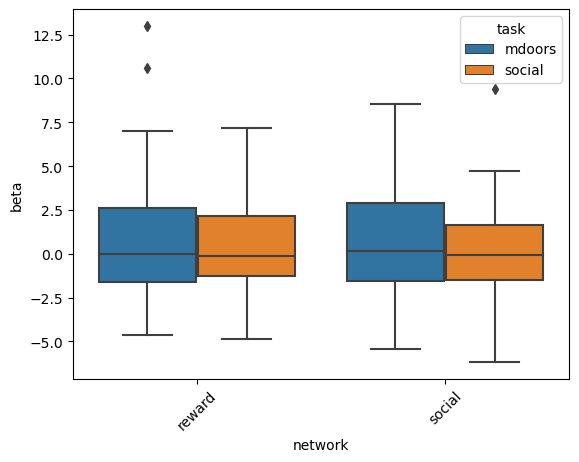

In [34]:
sns.boxplot(data=all_sub_ppi_roi_df, x='network', y='beta', hue='task')
plt.xticks(rotation=45)

# All Participants Group Average

In [7]:
# Define a grey matter mask
subj_mni_mask = bids_dir+'/derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'


In [78]:
# Define multiple comparisons parameters

# Control for false positive rate
mc = 'fdr'
alpha = 0.05

## Young Adults

In [49]:
from nilearn.glm.second_level import non_parametric_inference

In [81]:
# Make empty dictionary to store second level significance results
threshold_data = {}

# Define group prefix
group = 'adult'

# Remove bad subjects
subjs_scan_info = subjs_scan_info[subjs_scan_info['participant_id'] != 'sub-4069']

# Create list of young adult data
subjs_scan_info_adult = subjs_scan_info[subjs_scan_info['group'] == 'college']
print('There are ' + str(len(subjs_scan_info_adult))+ ' young adults')


for task in ['mdoors', 'social']:
    for net in ['reward', 'social']:
        print('Calculating second level results for '+group+' '+task+' nuis-'+net)
        
        # Find PPI maps
        file_list_adult_ppi = []
        
        for subj in subjs_scan_info_adult['participant_id']:
            # Search for subject task data
            temp_data_path = glob.glob(os.path.join(outp_dir,'subject_results',subj,
                                                    subj+'_ppi_task-'+task+'_'+'net-'+net+'.nii'))

            # Check to make sure task data exists for subject
            if len(temp_data_path) == 1:
                file_list_adult_ppi.append(temp_data_path[0])
                
        
        # Create a design matrix of just one column
        design_matrix = pd.DataFrame([1] * len(file_list_adult_ppi), columns=["intercept"])

        # Create second level model and fit the data and design matrix
        model = SecondLevelModel(mask_img=subj_mni_mask, smoothing_fwhm=8.0)
        model.fit(file_list_adult_ppi, design_matrix=design_matrix)

        #Compute a contrast map to see whether any regions are greater than 0
        z_map = model.compute_contrast(output_type='z_score')
        z_map.to_filename(os.path.join(outp_dir, 'group_results',
                                       'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+'unc.nii.gz'))

        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

        # Estimate true positives within a cluster
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh_clust = cluster_level_inference(z_map, alpha=0.05)


        z_map_thresh.to_filename(os.path.join(outp_dir,'group_results',
                                           'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(outp_dir,'group_results',
        #                                   'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))

        threshold_data['zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+mc+'-'+str(alpha)] = threshold
        


There are 30 young adults
Calculating second level results for adult mdoors nuis-reward
Calculating second level results for adult mdoors nuis-social
Calculating second level results for adult social nuis-reward
Calculating second level results for adult social nuis-social


### Monetary task, accounting for the reward network

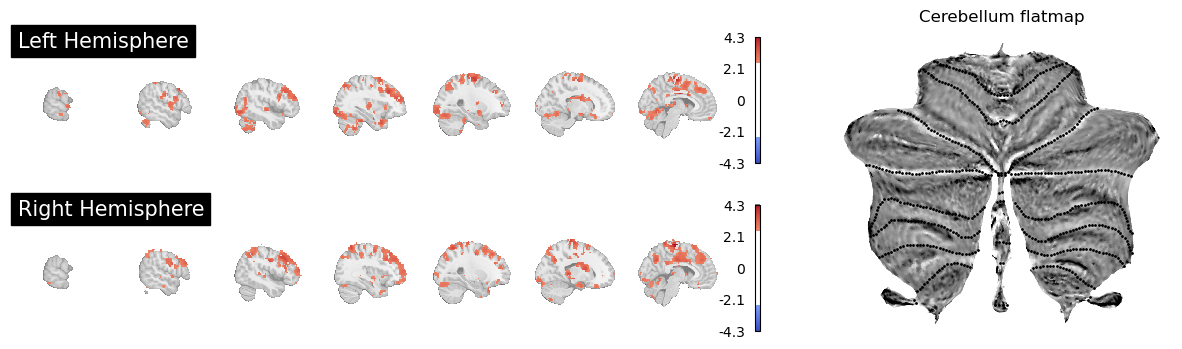

In [87]:
plot_stat_contours('zmap_ppi_adult_mdoors_nuis-reward', mc='fdr', mc_alpha=0.05, thresh=2.5)

### Monetary task, accounting for the social network

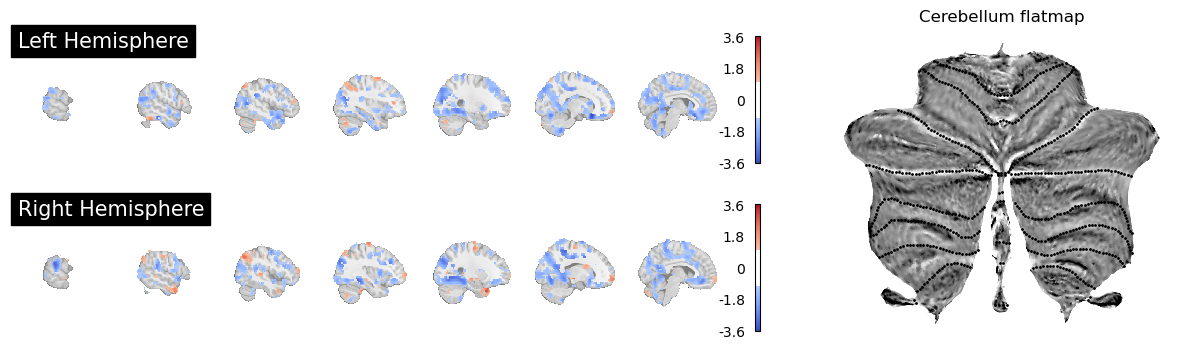

In [88]:
plot_stat_contours('zmap_ppi_adult_mdoors_nuis-social', mc='fdr', mc_alpha=0.05)

### Social task, accounting for the reward network

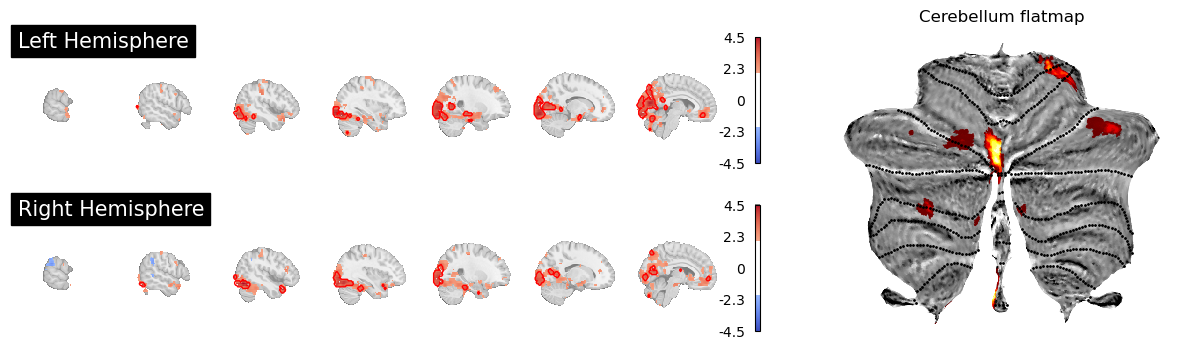

In [89]:
plot_stat_contours('zmap_ppi_adult_social_nuis-reward', mc='fdr', mc_alpha=0.05, thresh=2)

### Social task, accounting for the social network

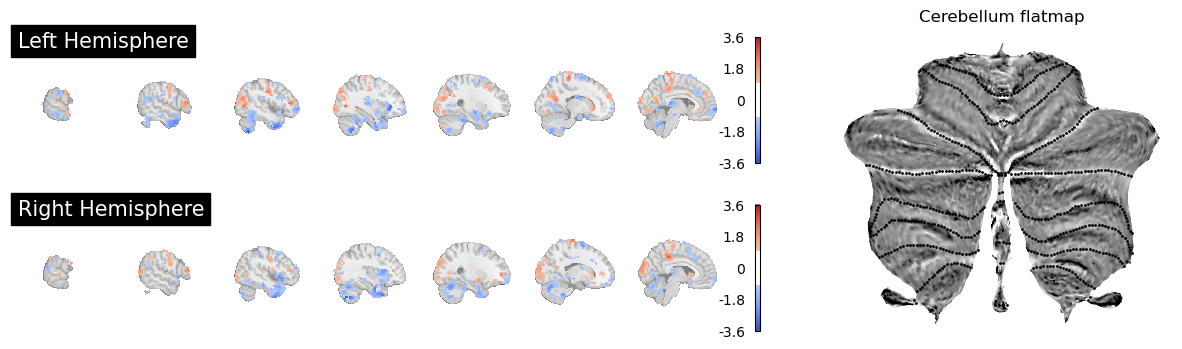

In [90]:
plot_stat_contours('zmap_ppi_adult_social_nuis-social', mc='fdr', mc_alpha=0.05)

## Adolescents

In [92]:
# Define group prefix
group = 'adole'

# Create list of young adult data
subjs_scan_info_adole = subjs_scan_info[subjs_scan_info['group'] == 'kid']
print('There are ' + str(len(subjs_scan_info_adole))+ ' adolescents')


for task in ['mdoors', 'social']:
    for net in ['reward', 'social']:
        print('Calculating second level results for '+group+' '+task+' nuis-'+net)
        
        # Find PPI maps
        file_list_ppi = []
        
        for subj in subjs_scan_info_adole['participant_id']:
            # Search for subject task data
            temp_data_path = glob.glob(os.path.join(outp_dir,'subject_results', subj,
                                                    subj+'_ppi_task-'+task+'_'+'net-'+net+'.nii'))

            # Check to make sure task data exists for subject
            if len(temp_data_path) == 1:
                file_list_ppi.append(temp_data_path[0])
                
        
        # Create a design matrix of just one column
        design_matrix = pd.DataFrame([1] * len(file_list_ppi), columns=["intercept"])

        # Create second level model and fit the data and design matrix
        model = SecondLevelModel(mask_img=subj_mni_mask, smoothing_fwhm=8.0)
        model.fit(file_list_ppi, design_matrix=design_matrix)

        #Compute a contrast map to see whether any regions are greater than 0
        z_map = model.compute_contrast(output_type='z_score')
        z_map.to_filename(os.path.join(outp_dir, 'group_results',
                                       'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+'unc.nii.gz'))

        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

        # Estimate true positives within a cluster
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)

        z_map_thresh.to_filename(os.path.join(outp_dir,'group_results',
                                           'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(outp_dir,'group_results',
        #                                   'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))

        threshold_data['zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+mc+'-'+str(alpha)] = threshold

There are 32 adolescents
Calculating second level results for adole mdoors nuis-reward
Calculating second level results for adole mdoors nuis-social
Calculating second level results for adole social nuis-reward
Calculating second level results for adole social nuis-social


### Monetary task, accounting for reward network

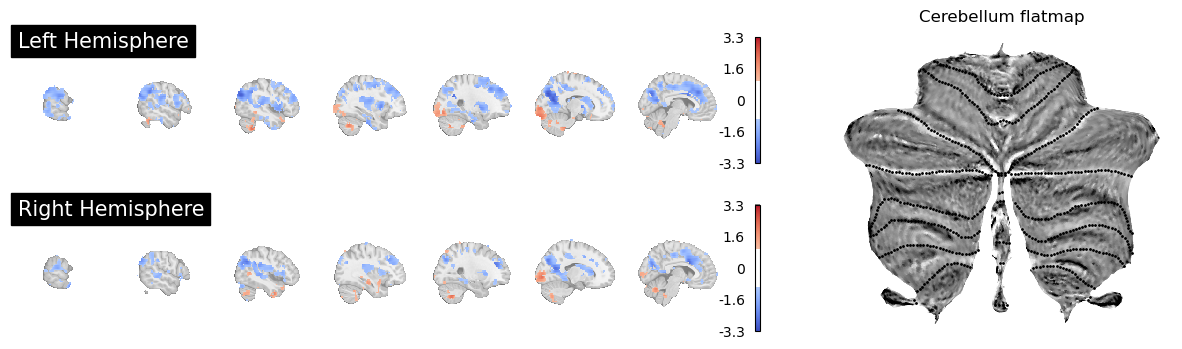

In [93]:
plot_stat_contours('zmap_ppi_adole_mdoors_nuis-reward', mc='fdr', mc_alpha=0.05)

### Monetary task, accounting for the social network

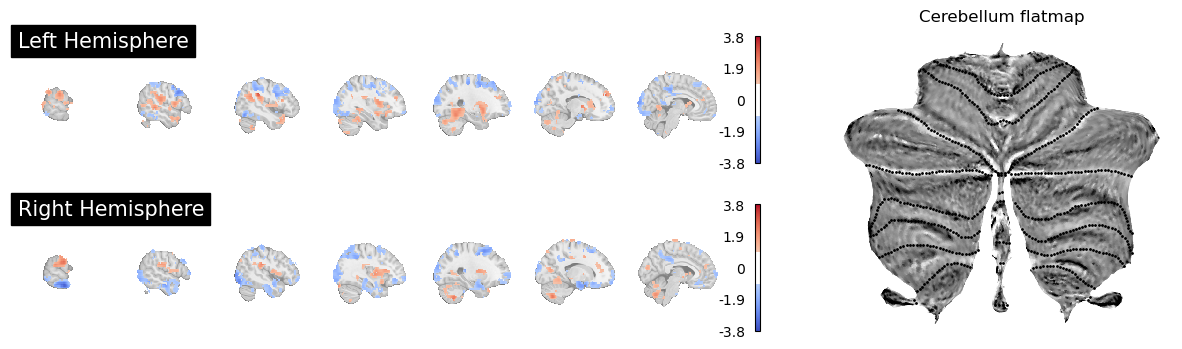

In [94]:
plot_stat_contours('zmap_ppi_adole_mdoors_nuis-social', mc='fdr', mc_alpha=0.05)

### Social task, accounting for the reward network

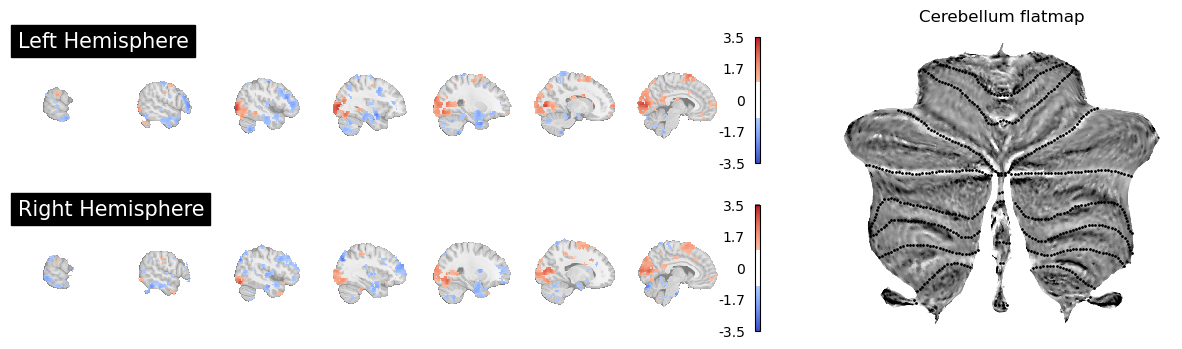

In [95]:
plot_stat_contours('zmap_ppi_adole_social_nuis-reward', mc='fdr', mc_alpha=0.05)

### Social task, accounting for the social network

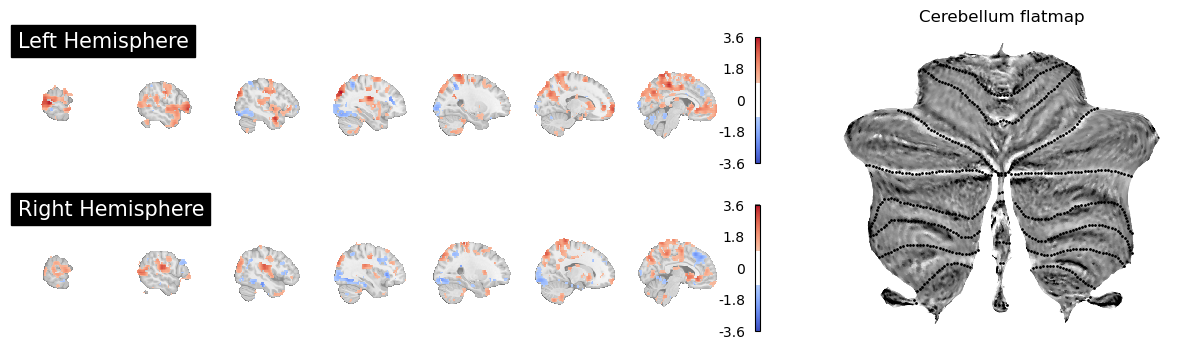

In [96]:
plot_stat_contours('zmap_ppi_adole_social_nuis-social', mc='fdr', mc_alpha=0.05)

# Between Groups

## Second Level Design Matrix

<AxesSubplot:label='conditions', ylabel='scan number'>

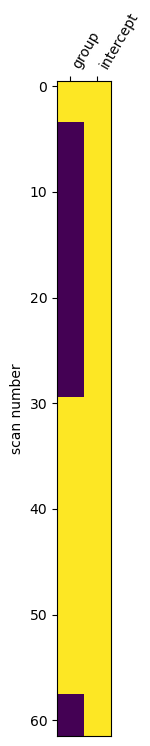

In [97]:
# Make a copy for the design matrix df
subjs_info_num = subjs_scan_info.copy()

# Remove bad subjects
subjs_info_num = subjs_info_num[subjs_info_num['participant_id'] != 'sub-4069']


# Turn values numeric
subjs_info_num = subjs_info_num.replace({'group': {'college': -1, 'kid': 1}})

# Remove irrelevant info
subjs_info_num = subjs_info_num.drop(columns=['age', 'sex', 'Unnamed: 0'])

# Change column header for needed function input
subjs_info_num = subjs_info_num.rename({'participant_id':'subject_label'}, axis='columns')

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [98]:
# Define group prefix
group = 'all'


for task in ['mdoors', 'social']:
    for net in ['reward', 'social']:
        print('Calculating second level results for '+group+' '+task+' nuis-'+net)
        
        # Create temporary subject dataframe to be modified for each analysis
        temp_subj_info = subjs_info_num.copy()
        
        # Find PPI maps
        file_list_ppi = []
        
        for subj in temp_subj_info['subject_label']:
            # Search for subject task data
            temp_data_path = glob.glob(os.path.join(outp_dir,'subject_results', subj,
                                                    subj+'_ppi_task-'+task+'_'+'net-'+net+'.nii'))

            # Check to make sure task data exists for subject
            if len(temp_data_path) == 1:
                file_list_ppi.append(temp_data_path[0])
            
            else:  # Remove subject from analysis
                temp_subj_info = temp_subj_info[temp_subj_info['subject_label'] != subj]
                
        
        # Create a design matrix of just one column
        design_matrix = make_second_level_design_matrix(temp_subj_info['subject_label'], 
                                                        temp_subj_info)

        # Create second level model and fit the data and design matrix
        model = SecondLevelModel(mask_img=subj_mni_mask, smoothing_fwhm=8.0)
        model.fit(file_list_ppi, design_matrix=design_matrix)
        
        for contrast in ['group', 'intercept']:
            #Compute a contrast map to see whether any regions are greater than 0
            z_map = model.compute_contrast(contrast, output_type='z_score')
            z_map.to_filename(os.path.join(outp_dir, 'group_results',
                                           'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+contrast+'_unc.nii.gz'))

            # Multiple Comparisons Correction
            z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

            # Estimate true positives within a cluster
            #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)

            z_map_thresh.to_filename(os.path.join(outp_dir,'group_results',
                                               'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+contrast+'_'+mc+'-'+str(alpha)+'.nii.gz'))
            #z_map_thresh_clust.to_filename(os.path.join(outp_dir,'group_results',
            #                                   'zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))

            threshold_data['zmap_ppi_'+group+'_'+task+'_nuis-'+net+'_'+contrast+'_'+mc+'-'+str(alpha)] = threshold

Calculating second level results for all mdoors nuis-reward
Calculating second level results for all mdoors nuis-social
Calculating second level results for all social nuis-reward
Calculating second level results for all social nuis-social


## Between Group Differences

### Monetary task, accounting for the reward network

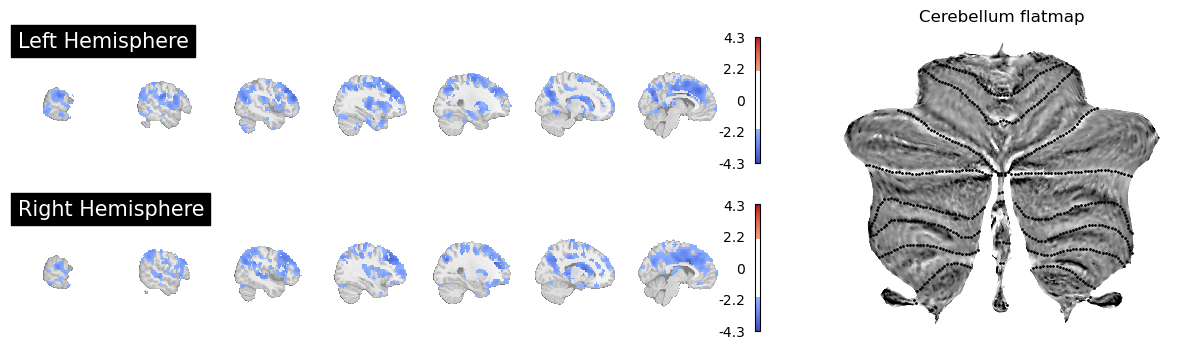

In [99]:
plot_stat_contours('zmap_ppi_all_mdoors_nuis-reward_group', mc='fdr', mc_alpha=0.05, thresh=2)

### Monetary task, accounting for the social network

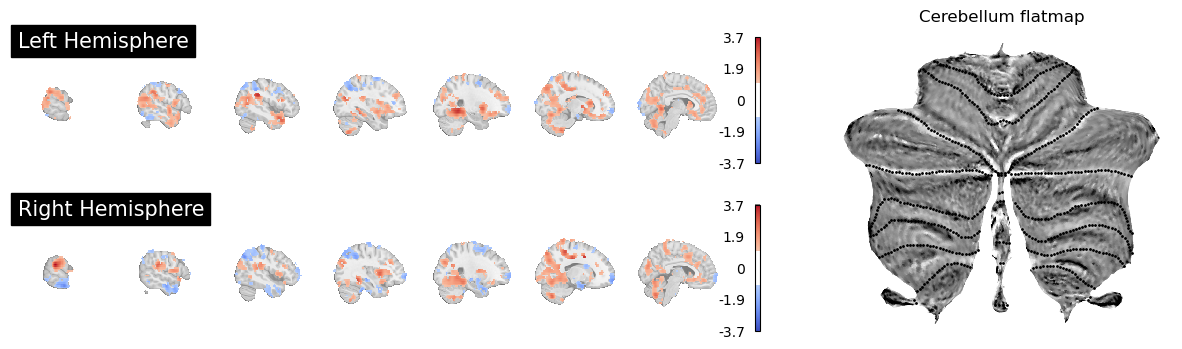

In [100]:
plot_stat_contours('zmap_ppi_all_mdoors_nuis-social_group', mc='fdr', mc_alpha=0.05)

### Social task, accounting for the reward network

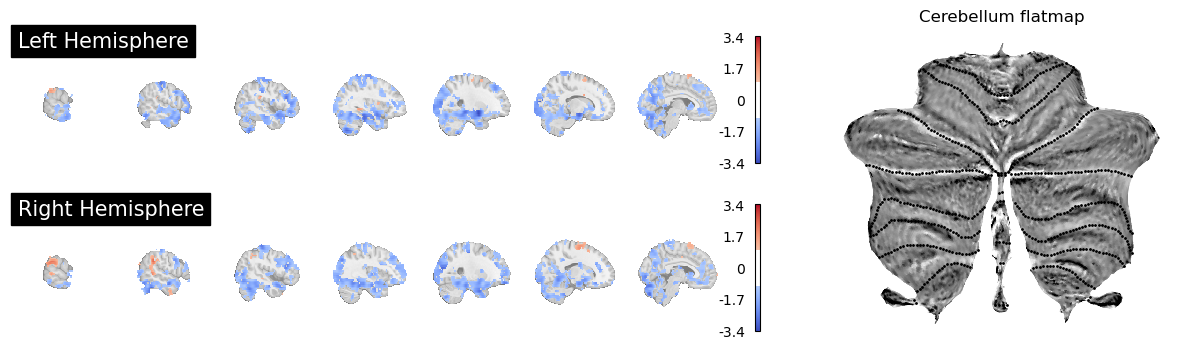

In [101]:
plot_stat_contours('zmap_ppi_all_social_nuis-reward_group', mc='fdr', mc_alpha=0.05)

### Social task, accounting for the Social network

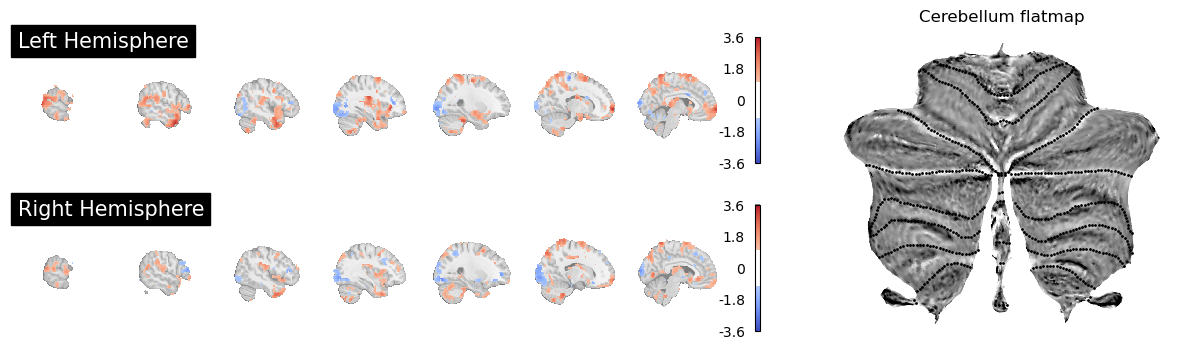

In [102]:
plot_stat_contours('zmap_ppi_all_social_nuis-social_group', mc='fdr', mc_alpha=0.05)

**Results:** No significant differences between adolescent and young adult connectivity between Crus I/II and the rest of the brain for all wins vs all losses. However, a liberal threshold shows stronger connectivity in the frontal pole and early visual cortex.

# Summary

Overall, there were no significant results after multiple comparisons correction (FDR < .05). However, some interesting trends hint at differences in Crus I/II connectivity with the cerebrum between adolescents and young adults for win trials over loss trials of the task. Connectivity between Crus I/II and the dlPFC, striatum, and early visual cortex is greater in adolescents than in young adults. This connectivity does not change significantly, when account for activity in either the reward or social networks.